# Challenge Machine Learning Engineer

## 1 Selección del Modelo:

Para empezar, Al ver el procesamiento de la data ambos modelos perfectamente podrían funcionar mejor solo que creo que faltaron considerar ciertas cosas.

Para el modelo de **Logistic Regression** faltó considerar que éste "piensa" que todos los _predictores_ son _independientes_ entre sí es decir que si este modelo se enfrenta a datos cuyos _features_ están altamente relacionados (correlación alta) los coeficientes aprendidos generarán una inestabilidad en la _línea de decisión_ que genera este modelo para la clasificación. En palabras más simples; predictores con alta correlación implica una clasificación menos exacta. Para este modelo hay que buscar la mayor variabilidad posible entre los features, de esta forma el modelo podría funcionar mejor. 

Lo mencionado anteriormente no se analizó y los features estaban altamente correlacionado al dejar la data transformada en vectores de 1's y 0's (resultado de hacer la transformación `get_dummies` con pandas). Una mejora o adaptación que se podría hacer es primero:
  
  - Hacer el análisis con una matriz de correlación. 
  - Seleccionar aquellos features con una correlación menor (valores cercanos a cero).
  - Probar el entrenamiento de este modelo.
  
Otra mejora que se puede hacer, que es más general, y que podría servir para ambos modelos es que a la data seleccionada realizarle una transformación PCA a 2 o 3 dimensiones (o n dimensiones) que tengan capturada la mayor variabilidad de la data original.

Con respecto al modelo **XGBoost**, por definición y trabajo interno del modelo debería funcionar mejor que _logistic regression_, ya que este modelo tiene mejor regularización en el aprendizaje y hace una mejor selección de predictores, sin embargo al igual que cualquier modelo de aprendizaje automático dependen mucho del procesamiento de los datos, como estamos en presencia de una data de 37 predictores al haber alta correlación entre ellos es probable que al modelo le cuesta hacer una selección de features para mejorar el aprendizaje. 

Ahora, para concretar las ideas, En cuanto a mejoras probaría lo sugerido anteriormente para ambos modelos y luego escoger un modelo. Sin embargo, si me preguntan qué modelo seleccionar previo  hacer pruebas, usaría **<span style="color:green">XGBoost</span>** puesto que este modelo es más escalable que el de regresión logística (funciona mejor con un mayor número de datos) y tiene más libertades de mejoras en cuanto al ajuste de hiperparámetros de modelo. 

___

A continuación se realizará todo lo que propongo como procesamiento de datos con la data ya seleccionada por Juan.


### 1.1 Preprocesamiento de Datos

In [56]:
#instalación de algunas librerías extras
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.7 MB/s eta 0:00:00


In [57]:
#Importando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

#Herramientas de sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import category_encoders as ce

#XGBoost
import xgboost as xgb

In [2]:
#Abriendo synthetic_features.csv
synt_feat = pd.read_csv('synthetic_features.csv')
synt_feat.head()

,temporada_alta,dif_min,atraso_15,periodo_dia
0,1,3.0,0,noche
1,1,9.0,0,noche
2,1,9.0,0,noche
3,1,3.0,0,noche
4,1,-2.0,0,noche


In [3]:
#Abriendo los features seleccionados por Juan
data = pd.read_csv('final_feat.csv',index_col='Unnamed: 0')
print(data.shape)
data.head(10)

(68206, 6)


,OPERA,MES,TIPOVUELO,SIGLADES,DIANOM,atraso_15
13375,Sky Airline,3,N,Antofagasta,Viernes,0
35799,Grupo LATAM,7,N,Concepcion,Jueves,0
48176,Grupo LATAM,9,N,Arica,Miercoles,0
58675,Grupo LATAM,11,N,Iquique,Viernes,0
23374,Sky Airline,5,N,Valdivia,Lunes,0
27666,Aerolineas Argentinas,6,I,Buenos Aires,Domingo,0
850,Qantas Airways,1,I,Sydney,Domingo,1
53131,Grupo LATAM,10,N,Puerto Montt,Miercoles,0
23976,Sky Airline,5,N,Iquique,Sabado,0
44265,Aeromexico,9,I,Ciudad de Mexico,Viernes,0


### 1.1.1. Sugerencia 1: Estudiar la alta correlación de la base de datos

En primer lugar se utilizará la data con los siguientes features seleccionados: `OPERA`, `MES`, `TIPOVUELO`,`SIGLADES`,`DIANOM`,`atraso_15` que fueron los predictores que Juan consideró relevantes.



In [4]:
features = data.drop(columns=['atraso_15'])

In [5]:
features1 = pd.concat([pd.get_dummies(data['OPERA'], prefix = 'OPERA'),pd.get_dummies(data['TIPOVUELO'], prefix = 'TIPOVUELO'), pd.get_dummies(data['MES'], prefix = 'MES')], axis = 1)
label = data['atraso_15']

In [6]:
features1

,OPERA_Aerolineas Argentinas,OPERA_Aeromexico,OPERA_Air Canada,OPERA_Air France,OPERA_Alitalia,OPERA_American Airlines,OPERA_Austral,OPERA_Avianca,OPERA_British Airways,OPERA_Copa Air,...,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
13375,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
35799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
48176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
58675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
23374,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
28790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
25257,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4820,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


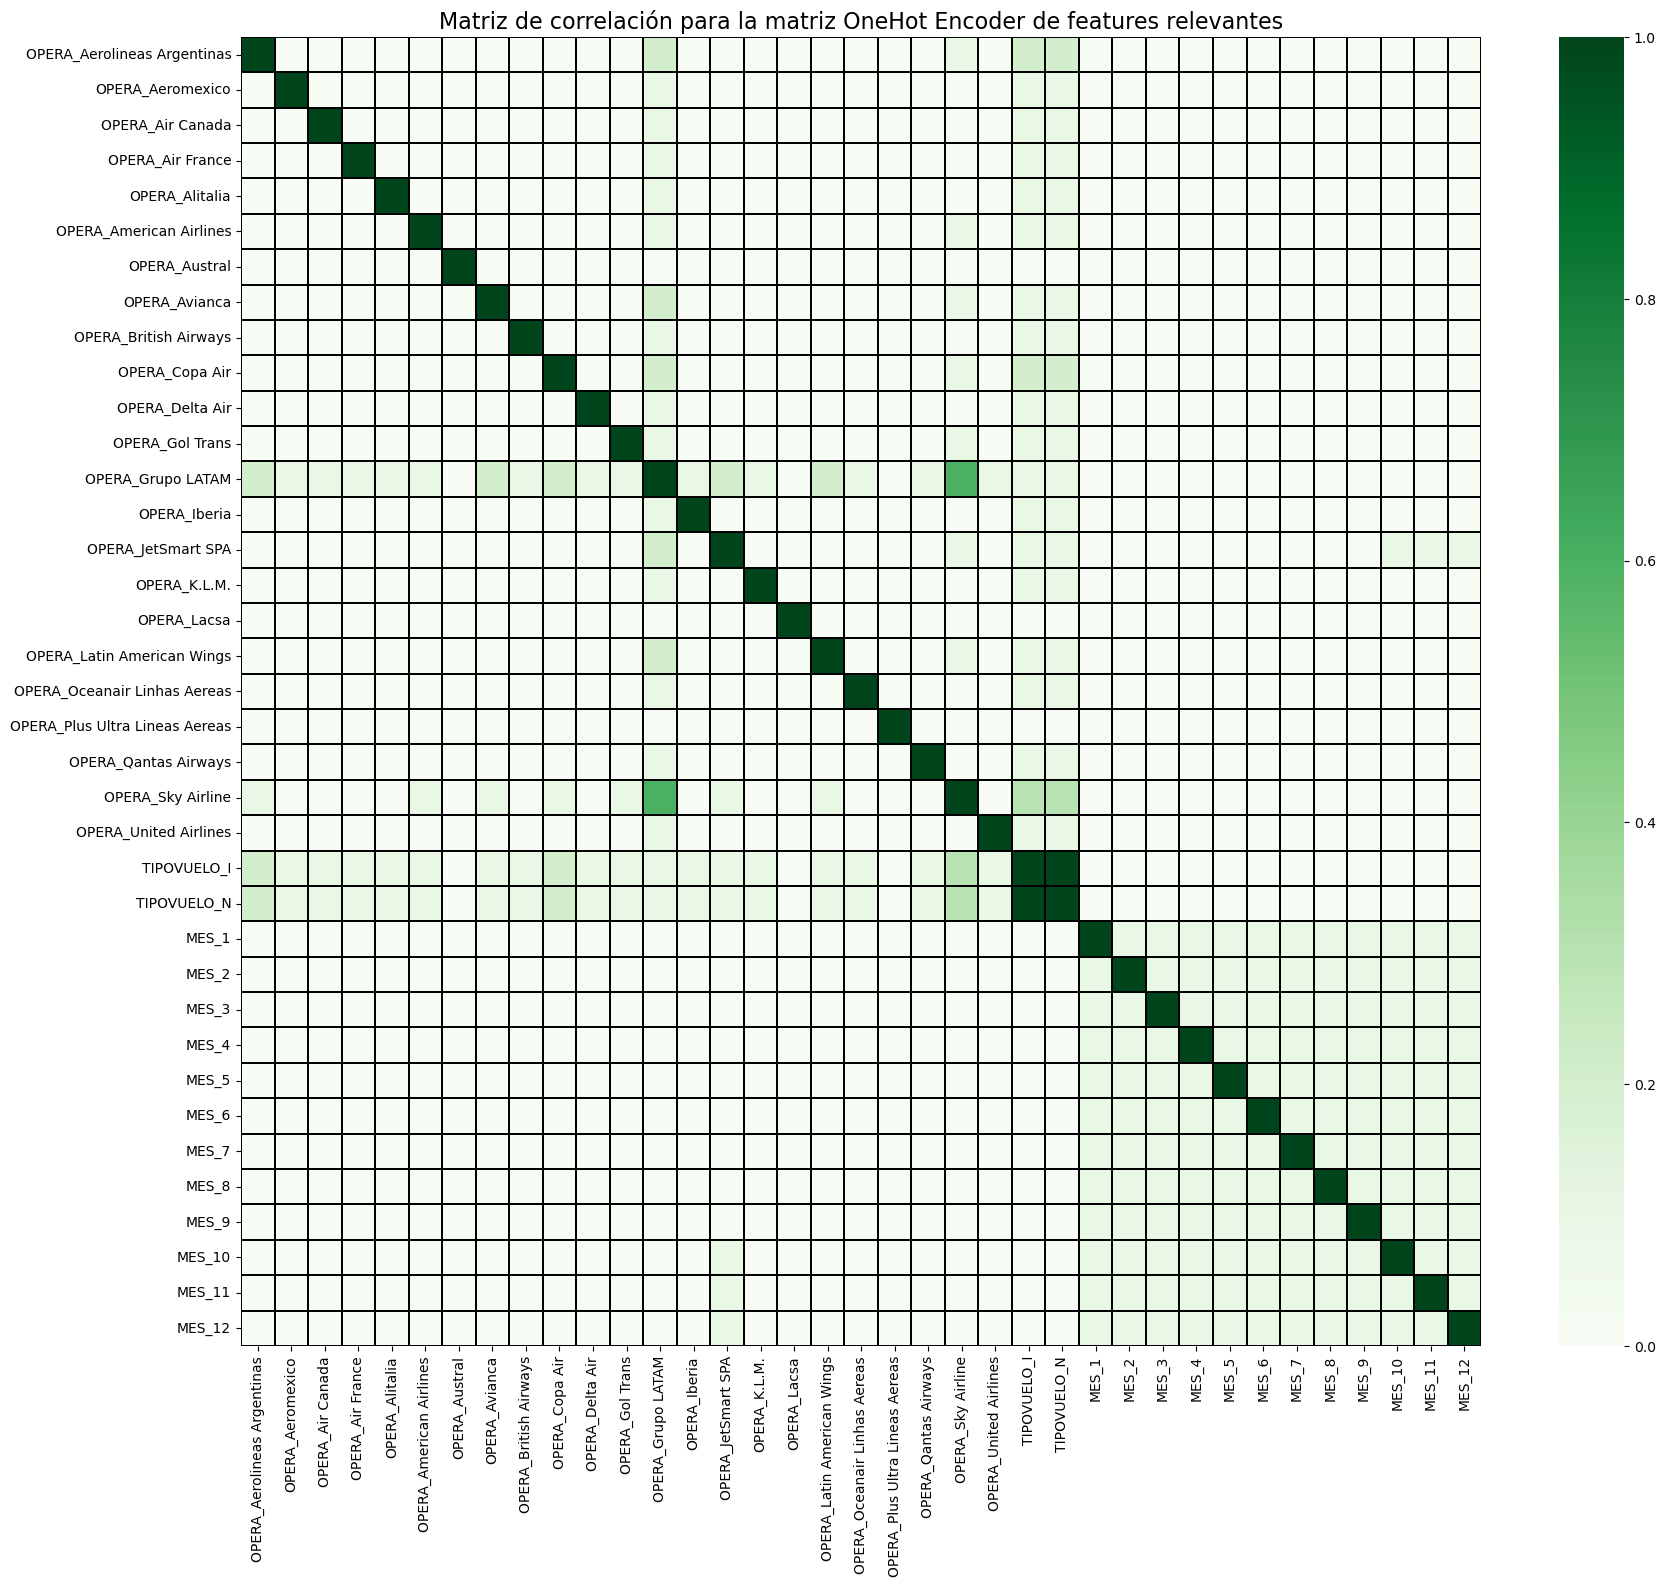

In [7]:
#matriz de correlación
corr_feat1 = np.abs(round(features1.corr(),1))
plt.figure(figsize=[20,17])
sn.heatmap(corr_feat1,cmap='Greens',annot=False,linewidths=.2,linecolor='black')
plt.title("Matriz de correlación para la matriz OneHot Encoder de features relevantes",fontsize=16)
plt.show()

Se aplicó valor absoluto a las correlaciones ya que de esa manera aquellos valores cercanos a 1 representan correlaciones altas, ya sea de forma positivo o negativa, que son las que complican al modelo. Solo se aprecian 2 variables altamente correlacionadas con valores muy crecanos a 1 que corresponden al tipo de vuelo, y otra medianamente correlacionada que corresponde a la Aerolínea utilizada. Visto lo anterior quitaré solo 2 variables ya que el resto no correlacionan fuertemente entre sí. eliminaré de esta data las Variables `OPERA_Sky Airline` y `TIPOVUELO_I`. 

In [8]:
features1.drop(columns=['OPERA_Sky Airline','TIPOVUELO_I'],inplace=True)
features1.columns

Index(['OPERA_Aerolineas Argentinas', 'OPERA_Aeromexico', 'OPERA_Air Canada',
       'OPERA_Air France', 'OPERA_Alitalia', 'OPERA_American Airlines',
       'OPERA_Austral', 'OPERA_Avianca', 'OPERA_British Airways',
       'OPERA_Copa Air', 'OPERA_Delta Air', 'OPERA_Gol Trans',
       'OPERA_Grupo LATAM', 'OPERA_Iberia', 'OPERA_JetSmart SPA',
       'OPERA_K.L.M.', 'OPERA_Lacsa', 'OPERA_Latin American Wings',
       'OPERA_Oceanair Linhas Aereas', 'OPERA_Plus Ultra Lineas Aereas',
       'OPERA_Qantas Airways', 'OPERA_United Airlines', 'TIPOVUELO_N', 'MES_1',
       'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8', 'MES_9',
       'MES_10', 'MES_11', 'MES_12'],
      dtype='object')

Bien, Ahora dejaremos esta matriz en _standby_ para hacer otros preprocesamientos a la base de datos, para finalmente escoger el mejor modelo.
___

### 1.1.2. Sugerencia 2: Transformación de los datos categóricos usando LabelEncoder.

Para esta sugerencia se realizará una transformación de la base de datos usando el método LabelEncoder en donde a cada valor categórico de una variable se le asiganárá un valor numérico, entonces don se encuentre ese valor categórico se reemplazará por el valor asignado.

In [9]:
features2 = {}
for col in features.columns:
    enc = LabelEncoder()
    col_enc = enc.fit_transform(features[col])
    features2[col]=col_enc
features2 = pd.DataFrame(features2)
features2

,OPERA,MES,TIPOVUELO,SIGLADES,DIANOM
0,21,2,1,0,6
1,12,6,1,16,1
2,12,8,1,1,4
3,12,10,1,24,6
4,21,4,1,60,2
...,...,...,...,...,...
68201,12,6,0,54,0
68202,21,5,1,27,6
68203,12,4,1,56,0
68204,12,0,0,8,1


Normalizando para que todas las variables se encuentren en la misma escala

In [10]:
minmax = MinMaxScaler()
features2_ = minmax.fit_transform(features2)
for i,col in enumerate(features.columns):
    features2[col]=features2_[:,i]
features2

,OPERA,MES,TIPOVUELO,SIGLADES,DIANOM
0,0.954545,0.181818,1.0,0.000000,1.000000
1,0.545455,0.545455,1.0,0.262295,0.166667
2,0.545455,0.727273,1.0,0.016393,0.666667
3,0.545455,0.909091,1.0,0.393443,1.000000
4,0.954545,0.363636,1.0,0.983607,0.333333
...,...,...,...,...,...
68201,0.545455,0.545455,0.0,0.885246,0.000000
68202,0.954545,0.454545,1.0,0.442623,1.000000
68203,0.545455,0.363636,1.0,0.918033,0.000000
68204,0.545455,0.000000,0.0,0.131148,0.166667


Analizamos las correlaciones de esta nueva base de datos.

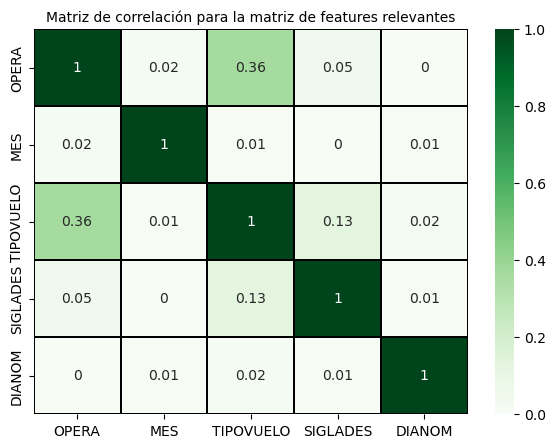

In [11]:
corr_feat2 = np.abs(round(features2.corr(),2))
plt.figure(figsize=[7,5])
sn.heatmap(corr_feat2,cmap='Greens',annot=True,linewidths=.2,linecolor='black')
plt.title("Matriz de correlación para la matriz de features relevantes",fontsize=10)
plt.show()

Solo hay una leve correlación entre las variables `TIPOVUELO` y `OPERA`, sin embargo, las dejaré ya que no es alta.
___

### 1.1.3. Sugerencia 3: Agregar las variables del dataset `synthetic_features.csv` 

En esta sugerencia, voy a agregar las variables pertenecientes al dataset `synthetic_features.csv` al dataset usado por Juan para hacer las predicciones, con la finalidad de agregar más información. Entonces, los pasos a seguir serán: 
 
 - fusionar los datasets `synthetic_features.csv` y `final_feat.csv`.
 - Transformar a dummy.
 - Analizar Correlación. 
 - Seleccionar features (si es necesario).
 

In [12]:
#Concatenando datasets y a la vez generando los dummies:
features3 = pd.concat([pd.get_dummies(data['OPERA'], prefix = 'OPERA'),
                       pd.get_dummies(data['MES'], prefix = 'MES'),
                       pd.get_dummies(data['TIPOVUELO'], prefix = 'TIPOVUELO'),
                       pd.get_dummies(data['SIGLADES'], prefix = 'SIGLADES'),
                       pd.get_dummies(data['DIANOM'], prefix = 'DIANOM'),
                       pd.get_dummies(synt_feat['periodo_dia'], prefix = 'periodo_dia'),
                       synt_feat['temporada_alta']
                      ],
                      axis=1)

In [13]:
features3.shape

(68206, 110)

Claramente no podré visualizar la matriz de confusión, entonces crearé un código que elimine aquellas correlaciones absolutas que superen el valor de 0.6 (escojo este valor para discriminar las ambigüedades de la información que traen los datos). 

In [14]:
corr_feat3 = np.abs(round(features3.corr(),2))

In [15]:
corr_feat3_bool = corr_feat3 >= 0.6 
sum_corr = corr_feat3_bool.sum()
var_corr = []
for i,suma in enumerate(sum_corr):
    if suma>=2:
        var_corr.append(sum_corr.index[i])
        
var_corr

['OPERA_Aeromexico',
 'OPERA_Air Canada',
 'OPERA_Air France',
 'OPERA_Alitalia',
 'OPERA_American Airlines',
 'OPERA_Avianca',
 'OPERA_British Airways',
 'OPERA_Copa Air',
 'OPERA_Delta Air',
 'OPERA_Grupo LATAM',
 'OPERA_Iberia',
 'OPERA_Qantas Airways',
 'OPERA_Sky Airline',
 'OPERA_United Airlines',
 'TIPOVUELO_I',
 'TIPOVUELO_N',
 'SIGLADES_Atlanta',
 'SIGLADES_Bogota',
 'SIGLADES_Ciudad de Mexico',
 'SIGLADES_Ciudad de Panama',
 'SIGLADES_Dallas',
 'SIGLADES_Houston',
 'SIGLADES_Londres',
 'SIGLADES_Madrid',
 'SIGLADES_Paris',
 'SIGLADES_Roma',
 'SIGLADES_Sydney',
 'SIGLADES_Toronto']

In [16]:
#Quitando estas variables:
features3.drop(columns=var_corr,inplace=True)
features3

,OPERA_Aerolineas Argentinas,OPERA_Austral,OPERA_Gol Trans,OPERA_JetSmart SPA,OPERA_K.L.M.,OPERA_Lacsa,OPERA_Latin American Wings,OPERA_Oceanair Linhas Aereas,OPERA_Plus Ultra Lineas Aereas,MES_1,...,DIANOM_Jueves,DIANOM_Lunes,DIANOM_Martes,DIANOM_Miercoles,DIANOM_Sabado,DIANOM_Viernes,periodo_dia_mañana,periodo_dia_noche,periodo_dia_tarde,temporada_alta
13375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
35799,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
48176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
58675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
23374,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
28790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
25257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4820,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,1


___
### 1.1.4. Sugerencia 4: Label Encoder para la concatenación de ambos datasets

Aquí sugerimos realizar una transformación, para las características categóricas, **LabelEncoder** para un dataset combinado entre `synthetic_features.csv` y `final_feat.csv`.


In [17]:
concat_feat = pd.concat([synt_feat[['temporada_alta','periodo_dia','dif_min']],
                         features],
                        axis=1)
features4 = {}
for col in concat_feat.columns:
    if col!='dif_min':
        enc = LabelEncoder()
        col_enc = enc.fit_transform(concat_feat[col])
        features4[col]=col_enc
    else:
        features4[col]=concat_feat[col]
features4 = pd.DataFrame(features4)
features4

,temporada_alta,periodo_dia,dif_min,OPERA,MES,TIPOVUELO,SIGLADES,DIANOM
0,1,1,3.0,5,0,0,34,0
1,1,1,9.0,5,0,0,34,2
2,1,1,9.0,5,0,0,34,3
3,1,1,3.0,5,0,0,34,4
4,1,1,-2.0,5,0,0,34,1
...,...,...,...,...,...,...,...,...
68201,1,2,46.0,14,11,0,28,6
68202,1,2,16.0,14,11,0,28,2
68203,1,2,40.0,14,11,0,28,4
68204,1,2,13.0,14,11,0,28,6


In [18]:
minmax2 = MinMaxScaler()
features4_ = minmax.fit_transform(features4)
for i,col in enumerate(features4.columns):
    features4[col]=features4_[:,i]
features4

,temporada_alta,periodo_dia,dif_min,OPERA,MES,TIPOVUELO,SIGLADES,DIANOM
0,1.0,0.333333,0.097143,0.227273,0.0,0.0,0.557377,0.000000
1,1.0,0.333333,0.131429,0.227273,0.0,0.0,0.557377,0.333333
2,1.0,0.333333,0.131429,0.227273,0.0,0.0,0.557377,0.500000
3,1.0,0.333333,0.097143,0.227273,0.0,0.0,0.557377,0.666667
4,1.0,0.333333,0.068571,0.227273,0.0,0.0,0.557377,0.166667
...,...,...,...,...,...,...,...,...
68201,1.0,0.666667,0.342857,0.636364,1.0,0.0,0.459016,1.000000
68202,1.0,0.666667,0.171429,0.636364,1.0,0.0,0.459016,0.333333
68203,1.0,0.666667,0.308571,0.636364,1.0,0.0,0.459016,0.666667
68204,1.0,0.666667,0.154286,0.636364,1.0,0.0,0.459016,1.000000


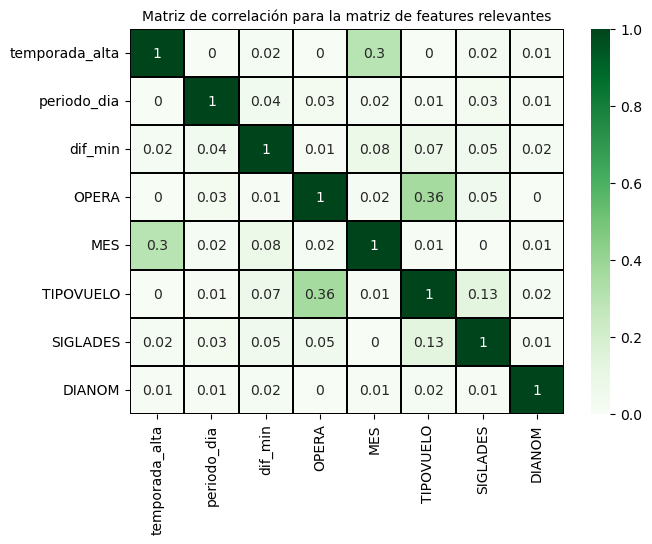

In [19]:
corr_feat4 = np.abs(round(features4.corr(),2))
plt.figure(figsize=[7,5])
sn.heatmap(corr_feat4,cmap='Greens',annot=True,linewidths=.2,linecolor='black')
plt.title("Matriz de correlación para la matriz de features relevantes",fontsize=10)
plt.show()

Apreciamos correlaciones bajas (<0.6) por lo que no es necesario quitar ninguna variable.

### 1.1.5. Sugerencia 5: Codificación de frecuencias para la el dataset concatenado.

en esta sugerencia usaré la codificación de frecuencias el cual codificará el valor categórico por la frecuencia de aparición en todo el dataset esto podría traer la información sobre aquellos vuelos que llegan tarde muy amenudo.

## 1.2 Probando modelos:

En esta sección voy a probar los modelos para cada sugerencia hecha de la sección anterior.

### 1.2.1. Entrenando y evaluando modelo para sugerencia 1:


#### 1.2.1.1. Logistic Regression:

Primero voy a hacer una separación **estratificada** del dataset, es decir, se intentará que tanto en el set de entrenamiento y en el set de validación/test tengan la misma proporción de datos con ambas clases. Lo anterior es debido a que la base de datos tiene un desbalance en cuanto a labels.

In [34]:
#separación

X_train, X_val, y_train, y_val = train_test_split(features1, label,
                                                  test_size=0.2,
                                                  stratify=label,
                                                  random_state=93
                                                 )

print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

x_train shape (54564, 35)
x_val shape (13642, 35)
y_train shape (54564,)
y_val shape (13642,)


Para hacer las pruebas también hay que hacer un ajuste de hiperparámetros para encontrar el mejor modelo

In [31]:
#Hiperparámetros a modificar
penalty = ['l1','l2']
solver = ['lbfgs','liblinear','newton-cg']
C = [0.1, 1.0, 10]
accuracy_sug1, parameters = [], []

for p in penalty:
    for s in solver:
        for c in C:
            if p=='l1' and s=='liblinear':
                lg = LogisticRegression(penalty = p, solver = s, C=c)
                lg.fit(X_train,y_train)
                y_pred = lg.predict(X_val)
                accuracy_sug1.append(round(accuracy_score(y_val, y_pred),3)*100)
                parameters.append((p,s,c))
            elif p=='l2':
                lg = LogisticRegression(penalty = p, solver = s, C=c)
                lg.fit(X_train,y_train)
                y_pred = lg.predict(X_val)
                accuracy_sug1.append(round(accuracy_score(y_val, y_pred),3)*100)
                parameters.append((p,s,c))

ind = accuracy_sug1.index(max(accuracy_sug1))
print("El modelo con mejor exactitud (",max(accuracy_sug1),"%) tiene los siguientes hiperparámetros:")
print("\tpenalty:",parameters[ind][0],"\n\tsolver:",parameters[ind][1],"\n\tC:",parameters[ind][2])
                
                

/home/juanito/anaconda3/envs/Python3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


El modelo con mejor exactitud ( 81.6 %) tiene los siguientes hiperparámetros:
	penalty: l1 
	solver: liblinear 
	C: 0.1


In [32]:
#lg = LogisticRegression(penalty = 'l2',solver = 'lbfgs',)
#lg.fit(X_train,y_train)
#y_pred = lg.predict(X_val)

#cm = confusion_matrix(y_val, y_pred)
#print(cm)
#print("accuracy:", round(accuracy_score(y_val, y_pred),3)*100,"%")

#print(classification_report(y_val, y_pred))

#### 1.2.1.2. XGBoost

In [33]:
#Hiperparámetros a modificar
learning_rate = [0.001,0.01,0.1,0.5]
max_depth = [2,3,5,10]
n_estimator = [100, 1000]
colsample_bytree = [0.5, 0.7, 0.8, 1.0]
subsample = [0.5, 0.7, 0.8, 1.0]

accuracy_sug1, parameters = [], []

for lr in learning_rate:d
    for md in max_depth:
        for ne in n_estimator:
            for col in colsample_bytree:
                for subs in subsample:
                    modeloxgb = xgb.XGBClassifier(random_state=93,
                                                 learning_rate=lr,
                                                 max_depth=md,
                                                 n_estimator=ne,
                                                 colsample_bytree=col,
                                                 subsample=subs)
                    modeloxgb.fit(X_train,y_train)
                    y_pred = modeloxgb.predict(X_val)
                    accuracy_sug1.append(round(accuracy_score(y_val, y_pred),3)*100)
                    parameters.append((lr,md,ne,col,subs))


ind = accuracy_sug1.index(max(accuracy_sug1))
print("El modelo con mejor exactitud (",max(accuracy_sug1),"%) tiene los siguientes hiperparámetros:")
print("\tlearning rate:",parameters[ind][0],"\n\tmaxima profundidad:",parameters[ind][1],"\n\tn_estimator:",parameters[ind][2],"\n\tcolsample_bytree",parameters[ind][3],"\n\tsubsample",parameters[ind][4])
                
                

[14:16:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:16:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:16:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:16:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:16:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:16:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:16:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:16:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:16:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:16:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:16:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:16:36] WARNING: .

[14:17:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:17:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:17:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:17:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:17:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:18:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:18:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:18:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:18:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:18:08] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:18:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:18:12] WARNING: .

[14:20:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:20:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:20:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:20:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:20:18] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:20:19] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:20:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:20:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:20:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:20:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:20:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:20:28] WARNING: .

[14:23:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:23:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:23:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:23:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:23:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:23:18] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:23:19] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:23:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:23:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:23:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:23:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:23:23] WARNING: .

[14:25:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:25:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:25:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:25:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:25:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:25:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:26:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:26:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:26:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:26:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:26:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:26:19] WARNING: .

[14:27:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:27:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:27:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:27:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:27:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:27:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:28:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:28:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:28:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:28:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:28:08] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[14:28:09] WARNING: .

In [29]:
modelxgb = xgb.XGBClassifier(random_state=93, learning_rate=0.001,max_depth=20,n_estimator=100)
modelxgb.fit(X_train, y_train)
y_pred = modelxgb.predict(X_val)

cm = confusion_matrix(y_val, y_pred)
print(cm)
print("accuracy:", round(accuracy_score(y_val, y_pred),3)*100,"%")

print(classification_report(y_val, y_pred))

[02:04:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[[8301   38]
 [1825   67]]
accuracy: 81.8 %
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      8339
           1       0.64      0.04      0.07      1892

    accuracy                           0.82     10231
   macro avg       0.73      0.52      0.48     10231
weighted avg       0.79      0.82      0.75     10231



___
### 1.2.2. Entrenando y evaluando modelo para sugerencia 2:


In [35]:
#separación

X_train, X_val, y_train, y_val = train_test_split(features2, label,
                                                  test_size=0.2,
                                                  stratify=label,
                                                  random_state=93
                                                 )

print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

x_train shape (54564, 5)
x_val shape (13642, 5)
y_train shape (54564,)
y_val shape (13642,)


#### 1.2.2.1. Logistic Regression:


In [36]:
#Hiperparámetros a modificar
penalty = ['l1','l2']
solver = ['lbfgs','liblinear','newton-cg']
C = [0.1, 1.0, 10]
accuracy_sug1, parameters = [], []

for p in penalty:
    for s in solver:
        for c in C:
            if p=='l1' and s=='liblinear':
                lg = LogisticRegression(penalty = p, solver = s, C=c)
                lg.fit(X_train,y_train)
                y_pred = lg.predict(X_val)
                accuracy_sug1.append(round(accuracy_score(y_val, y_pred),3)*100)
                parameters.append((p,s,c))
            elif p=='l2':
                lg = LogisticRegression(penalty = p, solver = s, C=c)
                lg.fit(X_train,y_train)
                y_pred = lg.predict(X_val)
                accuracy_sug1.append(round(accuracy_score(y_val, y_pred),3)*100)
                parameters.append((p,s,c))

ind = accuracy_sug1.index(max(accuracy_sug1))
print("El modelo con mejor exactitud (",max(accuracy_sug1),"%) tiene los siguientes hiperparámetros:")
print("\tpenalty:",parameters[ind][0],"\n\tsolver:",parameters[ind][1],"\n\tC:",parameters[ind][2])
                
                

El modelo con mejor exactitud ( 81.5 %) tiene los siguientes hiperparámetros:
	penalty: l1 
	solver: liblinear 
	C: 0.1


#### 1.2.2.2. XGBoost

In [38]:
#Hiperparámetros a modificar
learning_rate = [0.001,0.01,0.1,0.5]
max_depth = [2,3,5,10]
colsample_bytree = [0.5, 0.7, 0.8, 1.0]
subsample = [0.5, 0.7, 0.8, 1.0]

accuracy_sug1, parameters = [], []

for lr in learning_rate:
    for md in max_depth:
        for col in colsample_bytree:
            for subs in subsample:
                modeloxgb = xgb.XGBClassifier(random_state=93,
                                                 learning_rate=lr,
                                                 max_depth=md,
                                                 colsample_bytree=col,
                                                 subsample=subs)
                modeloxgb.fit(X_train,y_train)
                y_pred = modeloxgb.predict(X_val)
                accuracy_sug1.append(round(accuracy_score(y_val, y_pred),3)*100)
                parameters.append((lr,md,col,subs))


ind = accuracy_sug1.index(max(accuracy_sug1))
print("El modelo con mejor exactitud (",max(accuracy_sug1),"%) tiene los siguientes hiperparámetros:")
print("\tlearning rate:",parameters[ind][0],"\n\tmaxima profundidad:",parameters[ind][1],"\n\tcolsample_bytree",parameters[ind][2],"\n\tsubsample",parameters[ind][3])
                
                

El modelo con mejor exactitud ( 82.0 %) tiene los siguientes hiperparámetros:
	learning rate: 0.1 
	maxima profundidad: 5 
	colsample_bytree 0.7 
	subsample 0.5


___
### 1.2.3. Entrenando y evaluando modelo para sugerencia 3:


In [39]:
X_train, X_val, y_train, y_val = train_test_split(features3, label,
                                                  test_size=0.2,
                                                  stratify=label,
                                                  random_state=93
                                                 )

print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

x_train shape (54564, 82)
x_val shape (13642, 82)
y_train shape (54564,)
y_val shape (13642,)


#### 1.2.3.1. Logistic Regression:


In [41]:
#Hiperparámetros a modificar
penalty = ['l1','l2']
solver = ['lbfgs','liblinear','newton-cg']
C = [0.1, 1.0, 10]
accuracy_sug3, parameters3 = [], []

for p in penalty:
    for s in solver:
        for c in C:
            if p=='l1' and s=='liblinear':
                lg = LogisticRegression(penalty = p, solver = s, C=c)
                lg.fit(X_train,y_train)
                y_pred = lg.predict(X_val)
                accuracy_sug3.append(round(accuracy_score(y_val, y_pred),3)*100)
                parameters3.append((p,s,c))
            elif p=='l2':
                lg = LogisticRegression(penalty = p, solver = s, C=c)
                lg.fit(X_train,y_train)
                y_pred = lg.predict(X_val)
                accuracy_sug3.append(round(accuracy_score(y_val, y_pred),3)*100)
                parameters3.append((p,s,c))

ind = accuracy_sug3.index(max(accuracy_sug3))
print("El modelo con mejor exactitud (",max(accuracy_sug3),"%) tiene los siguientes hiperparámetros:")
print("\tpenalty:",parameters3[ind][0],"\n\tsolver:",parameters3[ind][1],"\n\tC:",parameters3[ind][2])
                
                

/home/juanito/anaconda3/envs/Python3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/juanito/anaconda3/envs/Python3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

El modelo con mejor exactitud ( 81.6 %) tiene los siguientes hiperparámetros:
	penalty: l1 
	solver: liblinear 
	C: 0.1


#### 1.2.3.2. XGBoost

In [43]:
#Hiperparámetros a modificar
learning_rate = [0.001,0.01,0.1,0.5]
max_depth = [2,3,5,10]
colsample_bytree = [0.5, 0.7, 0.8, 1.0]
subsample = [0.5, 0.7, 0.8, 1.0]

accuracy_sug3, parameters3 = [], []

for lr in learning_rate:
    for md in max_depth:
        for col in colsample_bytree:
            for subs in subsample:
                modeloxgb = xgb.XGBClassifier(random_state=93,
                                                 learning_rate=lr,
                                                 max_depth=md,
                                                 colsample_bytree=col,
                                                 subsample=subs)
                modeloxgb.fit(X_train,y_train)
                y_pred = modeloxgb.predict(X_val)
                accuracy_sug3.append(round(accuracy_score(y_val, y_pred),3)*100)
                parameters3.append((lr,md,col,subs))


ind = accuracy_sug3.index(max(accuracy_sug3))
print("El modelo con mejor exactitud (",max(accuracy_sug3),"%) tiene los siguientes hiperparámetros:")
print("\tlearning rate:",parameters3[ind][0],"\n\tmaxima profundidad:",parameters3[ind][1],"\n\tcolsample_bytree",parameters3[ind][2],"\n\tsubsample",parameters3[ind][3])
                
                

El modelo con mejor exactitud ( 82.0 %) tiene los siguientes hiperparámetros:
	learning rate: 0.5 
	maxima profundidad: 3 
	colsample_bytree 0.8 
	subsample 0.8


___
### 1.2.3. Entrenando y evaluando modelo para sugerencia 4:

In [46]:
X_train, X_val, y_train, y_val = train_test_split(features4, label,
                                                  test_size=0.2,
                                                  stratify=label,
                                                  random_state=93
                                                 )

print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

x_train shape (54564, 8)
x_val shape (13642, 8)
y_train shape (54564,)
y_val shape (13642,)


#### 1.2.3.1. Logistic Regression:


In [47]:
#Hiperparámetros a modificar
penalty = ['l1','l2']
solver = ['lbfgs','liblinear','newton-cg']
C = [0.1, 1.0, 10]
accuracy_sug4, parameters4 = [], []

for p in penalty:
    for s in solver:
        for c in C:
            if p=='l1' and s=='liblinear':
                lg = LogisticRegression(penalty = p, solver = s, C=c)
                lg.fit(X_train,y_train)
                y_pred = lg.predict(X_val)
                accuracy_sug4.append(round(accuracy_score(y_val, y_pred),3)*100)
                parameters4.append((p,s,c))
            elif p=='l2':
                lg = LogisticRegression(penalty = p, solver = s, C=c)
                lg.fit(X_train,y_train)
                y_pred = lg.predict(X_val)
                accuracy_sug4.append(round(accuracy_score(y_val, y_pred),3)*100)
                parameters4.append((p,s,c))

ind = accuracy_sug4.index(max(accuracy_sug4))
print("El modelo con mejor exactitud (",max(accuracy_sug4),"%) tiene los siguientes hiperparámetros:")
print("\tpenalty:",parameters4[ind][0],"\n\tsolver:",parameters4[ind][1],"\n\tC:",parameters4[ind][2])
                
                

El modelo con mejor exactitud ( 81.5 %) tiene los siguientes hiperparámetros:
	penalty: l1 
	solver: liblinear 
	C: 0.1


#### 1.2.3.2. XGBoost

In [48]:
#Hiperparámetros a modificar
learning_rate = [0.001,0.01,0.1,0.5]
max_depth = [2,3,5,10]
colsample_bytree = [0.5, 0.7, 0.8, 1.0]
subsample = [0.5, 0.7, 0.8, 1.0]

accuracy_sug4, parameters4 = [], []

for lr in learning_rate:
    for md in max_depth:
        for col in colsample_bytree:
            for subs in subsample:
                modeloxgb = xgb.XGBClassifier(random_state=93,
                                                 learning_rate=lr,
                                                 max_depth=md,
                                                 colsample_bytree=col,
                                                 subsample=subs)
                modeloxgb.fit(X_train,y_train)
                y_pred = modeloxgb.predict(X_val)
                accuracy_sug4.append(round(accuracy_score(y_val, y_pred),3)*100)
                parameters4.append((lr,md,col,subs))


ind = accuracy_sug4.index(max(accuracy_sug4))
print("El modelo con mejor exactitud (",max(accuracy_sug4),"%) tiene los siguientes hiperparámetros:")
print("\tlearning rate:",parameters4[ind][0],"\n\tmaxima profundidad:",parameters4[ind][1],"\n\tcolsample_bytree",parameters3[ind][2],"\n\tsubsample",parameters3[ind][3])
                
                

El modelo con mejor exactitud ( 81.5 %) tiene los siguientes hiperparámetros:
	learning rate: 0.001 
	maxima profundidad: 2 
	colsample_bytree 0.5 
	subsample 0.5
